# Objective: can we guess a baseball players position from their other stats?

https://www.openml.org/d/185


In [1]:
from sklearn import datasets
import pandas as pd

dataset = datasets.fetch_openml(name='baseball')
target ='Position'

positions = ['Catcher', 'Designated Hitter', 'First Base',
             'Outfield', 'Second Base', 'Short Stop', 'Third Base']

labeled_dataframe = pd.DataFrame(dataset.data, columns=dataset.feature_names).dropna()
labeled_dataframe.sample(7).T

716       777       1034      1256      634       932   \
Number_seasons     15.000    11.000    10.000    25.000    16.000    19.000   
Games_played     1666.000   542.000  1044.000  2383.000  1622.000  2466.000   
At_bats          5940.000  1557.000  3725.000  8618.000  5993.000  9358.000   
Runs              836.000   182.000   603.000  1057.000   819.000  1272.000   
Hits             1658.000   432.000  1063.000  2309.000  1778.000  2712.000   
Doubles           222.000    72.000   165.000   391.000   337.000   526.000   
Triples            49.000    16.000    20.000   143.000    76.000    75.000   
Home_runs         114.000    25.000   192.000    34.000   148.000   339.000   
RBIs              563.000   209.000   717.000  1121.000  1020.000  1493.000   
Walks             552.000    90.000   587.000   774.000   386.000   683.000   
Strikeouts        383.000   114.000   385.000    79.000   694.000  1537.000   
Batting_average     0.279     0.277     0.285     0.268     0.297     0.290   
On_base_pct         0.342     0.319     0.386     0.331     0.342     0.342   
Slugging_pct        0.391     0.392     0.495     0.358     0.452     0.471   
Fielding_ave        0.989     0.990     0.961     0.938     0.992     0.965   
Position            2.000     2.000     6.000     5.000     2.000     3.000   

                     583   
Number_seasons     11.000  
Games_played      857.000  
At_bats          2694.000  
Runs              309.000  
Hits              724.000  
Doubles           133.000  
Triples            17.000  
Home_runs          81.000  
RBIs              411.000  
Walks             214.000  
Strikeouts        402.000  
Batting_average     0.269  
On_base_pct         0.326  
Slugging_pct        0.421  
Fielding_ave        0.993  
Position            2.000

In [2]:
position_counts = labeled_dataframe[target].value_counts().sort_index()
position_counts.index = positions

position_counts

Catcher              252
Designated Hitter      8
First Base           137
Outfield             483
Second Base          146
Short Stop           153
Third Base           141
Name: Position, dtype: int64

In [3]:
y = labeled_dataframe[target]
X = labeled_dataframe.drop(target, axis=1)

print(X.shape)

(1320, 15)


# So what is a random forest?

![title](images\\random_forest.png)

source: https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d


# Score, and cross-validated scores
As we have seen, every estimator exposes a score method that can judge the quality of the fit (or the prediction) on new data. Bigger is better. 

## starting with a single fold
using the `train_test_split`

In [4]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

model = RandomForestClassifier(n_estimators=10, random_state=0)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, 
                                                random_state=0)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)


mat = confusion_matrix(ytest, ypred)
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=positions, yticklabels=positions)
plt.xlabel('true label')
plt.ylabel('predicted label')

print(model.score(Xtest, ytest))

0.5303030303030303
Wall time: 914 ms


In [ ]:
confusion_matrix?

To get a better measure of prediction accuracy (which we can use as a proxy for goodness of fit of the model), we can successively split the data in folds that we use for training and testing:

# manual cross validation

In [ ]:
%%time

import numpy as np
X_folds = np.array_split(X, 5)
y_folds = np.array_split(y, 5)

for k in range(5):
    # We use 'list' to copy, in order to 'pop' later on
    X_train = list(X_folds)
    X_test = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test = y_train.pop(k)
    y_train = np.concatenate(y_train)
    score = model.fit(X_train, y_train).score(X_test, y_test)
    print(score)  

0.553030303030303
0.5113636363636364
0.5643939393939394
0.5909090909090909
0.571969696969697
Wall time: 359 ms


![title](images\\folds.png)
source: https://stackoverflow.com/questions/31947183/how-to-implement-walk-forward-testing-in-sklearn

# automated cross validation

easier on the eyes

In [ ]:
%%time

from sklearn.model_selection import cross_validate
cv_score = cross_validate(model, X, y, cv=5, return_train_score=True)

print(pd.DataFrame(cv_score).mean())

fit_time       0.073297
score_time     0.005401
test_score     0.560675
train_score    0.985226
dtype: float64
Wall time: 494 ms


# Fancier folds

fit_time       0.070549
score_time     0.006503
test_score     0.565909
train_score    0.986458
dtype: float64
Wall time: 945 ms


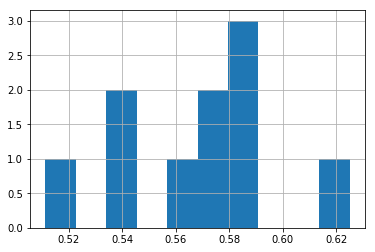

In [ ]:
%%time

from sklearn.model_selection import RepeatedKFold

repeate_folder = RepeatedKFold(n_splits=5,
                               n_repeats=2,
                               random_state=0)

cv_score = cross_validate(model, X, y, cv=repeate_folder, 
                          return_train_score=True)

print(pd.DataFrame(cv_score).mean())

pd.DataFrame(cv_score).test_score.hist()

# hyperparameter selection

![title](images\\hyperparameters.png)
source: https://medium.com/datadriveninvestor/an-introduction-to-grid-search-ff57adcc0998

### Default parameters of RandomForestRegressor
* n_estimators=10
* criterion=’mse’
* max_depth=None
* min_samples_split=2
* min_samples_leaf=1
* min_weight_fraction_leaf=0.0
* max_features=’auto’
* max_leaf_nodes=None
* min_impurity_decrease=0.0
* min_impurity_split=None
* bootstrap=True
* oob_score=False
* n_jobs=None
* random_state=None
* verbose=0
* warm_start=False)

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid = {"max_features": [.5, 1],
              "min_samples_leaf": [1, 2, 4],
              "n_estimators": [10, 50, 250]}

gs = GridSearchCV(model, param_grid=param_grid,
                  cv=repeate_folder,
                  verbose=1, return_train_score=True)
gs.fit(X, y)

print(gs.best_params_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
gs.best_score_

In [ ]:
cv_score = cross_validate(gs.best_estimator_, X, y, cv=repeate_folder, 
                          return_train_score=True)

print(pd.DataFrame(cv_score).mean())
pd.DataFrame(cv_score).test_score.hist()

In [ ]:
gs.best_estimator_.fit(Xtrain, ytrain)
ypred = gs.best_estimator_.predict(Xtest)


mat = confusion_matrix(ytest, ypred)
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=positions, yticklabels=positions)
plt.xlabel('true label')
plt.ylabel('predicted label')

print(gs.best_estimator_.score(Xtest, ytest))